In [1]:
import pandas as pd
from pycaret.regression import *

## 한글설정

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# 경고
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()
    # colab 사용자는 system_name이 'Linux'로 확인

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux
        # colab에서는 runtime을 <꼭> 재시작 해야합니다.
        # 런타임을 재시작 하지 않고 폰트 설치를 하면 기본 설정 폰트가 로드되어 한글이 깨집니다.
        # !apt-get update -qq
        # !apt-get install fonts-nanum -qq  > /dev/null

        import matplotlib.font_manager as fm

        fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
        font = fm.FontProperties(fname=fontpath, size=9)
        fm._rebuild()
        font_family = "NanumBarunGothic"
    return font_family

<AxesSubplot:title={'center':'한글'}>

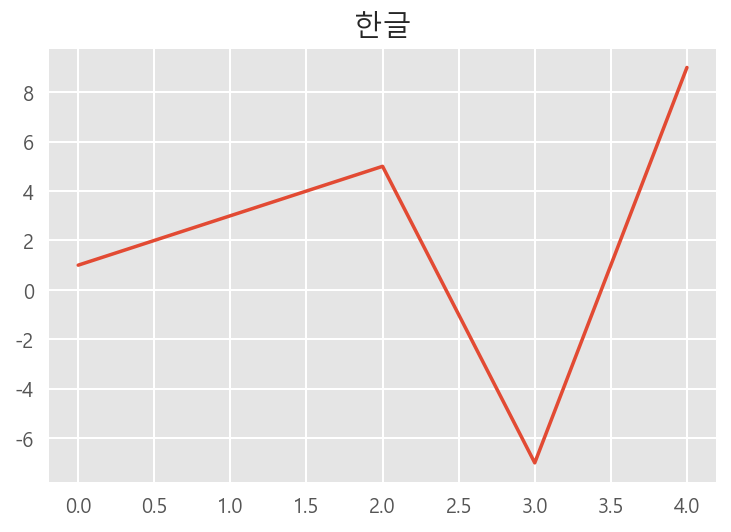

In [4]:
# 시각화를 위한 폰트설정
import matplotlib.pyplot as plt

# 위에서 만든 함수를 통해 시스템 폰트를 불러와서 font_family 라는 변수에 할당
font_family = get_font_family()

# 폰트설정
plt.rc("font", family=get_font_family())

# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)

# 그래프 스타일 설정
plt.style.use('ggplot')

# 그래프에 retina display 적용
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# 한글폰트 확인
pd.Series([1,3,5,-7,9]).plot(title="한글")

In [5]:
train = pd.read_csv("C:/Users/SisLab/!SOYEON/물류유통량예측경진대회/data/train.csv")
test = pd.read_csv("C:\\Users\\SisLab\\!SOYEON\\물류유통량예측경진대회\\data\\test.csv")

submission = pd.read_csv("C:\\Users\\SisLab\\!SOYEON\\물류유통량예측경진대회\\data\\sample_submission.csv")

In [6]:
train.head()

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3


In [7]:
test.head()

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리
0,0,4167000577042200,5011000435014100,선케어
1,1,1156000009012200,5011000172034400,구강위생용품
2,2,4122000363057300,5011000361097300,캠핑
3,3,5011000436041400,2826000084036400,아웃도어가구
4,4,4150000241065200,5011000169044300,분유/이유식/아기간식


In [8]:
submission.head()

,index,운송장_건수
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


# Train

In [9]:
train.columns = ['index','송하인','수하인','물품','운송장']

In [10]:
# 격자공간고유번호에서 시군구코드만 추출
train['송하인'] = train['송하인'].apply(str)
train['수하인'] = train['수하인'].apply(str)

# slice the index numbers
train['송하인'] = train['송하인'].str.slice(0,5)
train['수하인'] = train['수하인'].str.slice(0,5)

In [11]:
# 송하인
order_send = train.groupby('송하인').count()['운송장'].sort_values()
order_send_total = train.groupby('송하인').sum()['운송장'].sort_values()

# 수하인
order_recv = train.groupby('수하인').count()['운송장'].sort_values()
order_recv_total = train.groupby('수하인').sum()['운송장'].sort_values()

# 물품
catm_count = train.groupby('물품').count()['운송장'].sort_values(ascending=False)
catm_count_total = train.groupby('물품').sum()['운송장'].sort_values(ascending=False)

# Test

In [12]:
test.columns = ['index','송하인','수하인','물품']

In [13]:
# 격자공간고유번호에서 시군구코드만 추출
test['송하인'] = test['송하인'].apply(str)
test['수하인'] = test['수하인'].apply(str)

# slice the index numbers
test['송하인'] = test['송하인'].str.slice(0,5)
test['수하인'] = test['수하인'].str.slice(0,5)

## Feature 값 조정

In [14]:
# 송하인 정규화
avg_send = (order_send_total - min(order_send_total)) / (max(order_send_total) - min(order_send_total))
avg_send.rename('avg_send', inplace=True)
avg_send = avg_send.reset_index().rename(columns={'index': '송하인'})

# merge to train & test
train = pd.merge(left=train, right=avg_send, 
                 how='left', on=['송하인'])

test = pd.merge(left=test, right=avg_send, 
                 how='left', on=['송하인'])

In [15]:
# 수하인 정규화
avg_rec = (order_recv_total - min(order_recv_total)) / (max(order_recv_total) - min(order_recv_total))
avg_rec.rename('avg_rec', inplace=True)
avg_rec = avg_rec.reset_index().rename(columns={'index': '수하인'})
# merge to train & test
train = pd.merge(left=train, right=avg_rec, 
                 how='left', on=['수하인'])

test = pd.merge(left=test, right=avg_rec, 
                 how='left', on=['수하인'])

In [16]:
# 물품 정규화
avg_catb = (catm_count_total - min(catm_count_total)) / (max(catm_count_total) - min(catm_count_total))
avg_catb.rename('avg_catb', inplace=True)
avg_catb = avg_catb.reset_index().rename(columns={'index': '물품'})
# merge to train & test
train = pd.merge(left=train, right=avg_catb, 
                 how='left', on=['물품'])

test = pd.merge(left=test, right=avg_catb, 
                 how='left', on=['물품'])

In [29]:
# Training X and y
X = train.drop(['index', '송하인', '수하인', '물품'], axis=1)
y = train.운송장

# Testing X
X_test = test.drop(['index', '송하인', '수하인', '물품'], axis=1)

### Check

In [30]:
train.head()

,index,송하인,수하인,물품,운송장,avg_send,avg_rec,avg_catb
0,0,50110,28710,음반,3,1.000000,0.004367,0.026692
1,1,41480,50110,문화컨텐츠,3,0.107668,1.000000,0.061674
2,2,50110,11200,농산물,3,1.000000,0.016761,1.000000
3,3,41271,50110,기타식품,7,0.003013,1.000000,0.048249
4,4,50110,28237,농산물,3,1.000000,0.020971,1.000000


In [31]:
test.head()

,index,송하인,수하인,물품,avg_send,avg_rec,avg_catb
0,0,41670,50110,선케어,0.001632,1.00000,0.000945
1,1,11560,50110,구강위생용품,0.004229,1.00000,0.000626
2,2,41220,50110,캠핑,0.009074,1.00000,0.000342
3,3,50110,28260,아웃도어가구,1.000000,0.02811,0.000228
4,4,41500,50110,분유/이유식/아기간식,0.033115,1.00000,0.000877


In [32]:
X

,운송장,avg_send,avg_rec,avg_catb
0,3,1.000000,0.004367,0.026692
1,3,0.107668,1.000000,0.061674
2,3,1.000000,0.016761,1.000000
3,7,0.003013,1.000000,0.048249
4,3,1.000000,0.020971,1.000000
...,...,...,...,...
31679,3,0.002497,1.000000,0.000000
31680,4,0.008757,1.000000,0.000205
31681,6,0.008757,1.000000,0.000205
31682,7,0.008075,1.000000,0.000102


In [33]:
y

0        3
1        3
2        3
3        7
4        3
        ..
31679    3
31680    4
31681    6
31682    7
31683    4
Name: 운송장, Length: 31684, dtype: int64

In [34]:
X_test

,avg_send,avg_rec,avg_catb
0,0.001632,1.000000,0.000945
1,0.004229,1.000000,0.000626
2,0.009074,1.000000,0.000342
3,1.000000,0.028110,0.000228
4,0.033115,1.000000,0.000877
...,...,...,...
7915,1.000000,0.008812,1.000000
7916,0.006310,1.000000,0.061674
7917,0.774374,0.021050,1.000000
7918,0.774374,0.007034,1.000000


## Pycaret

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31684 entries, 0 to 31683
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   avg_send  31684 non-null  float64
 1   avg_rec   31684 non-null  float64
 2   avg_catb  31684 non-null  float64
dtypes: float64(3)
memory usage: 990.1 KB


In [35]:
df = setup(data = X, target = '운송장')

,Description,Value
0,session_id,8552
1,Target,운송장
2,Original Data,"(31684, 4)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(22178, 3)"


In [36]:
# 다양한 모델들과의 성능 비교
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,2.3366,37.2293,6.0221,0.0833,0.4347,0.4421,0.0600
catboost,CatBoost Regressor,2.3178,36.9726,6.0115,0.0747,0.4293,0.4354,1.6540
gbr,Gradient Boosting Regressor,2.3481,38.6222,6.1270,0.0574,0.4298,0.4453,0.2590
omp,Orthogonal Matching Pursuit,2.3993,41.2277,6.3072,0.0127,0.4365,0.4578,0.0060
lr,Linear Regression,2.4016,41.2222,6.3072,0.0126,0.4369,0.4584,0.3370
ridge,Ridge Regression,2.4016,41.2222,6.3072,0.0126,0.4369,0.4584,0.0070
lar,Least Angle Regression,2.4016,41.2222,6.3072,0.0126,0.4369,0.4584,0.0070
br,Bayesian Ridge,2.4014,41.2216,6.3071,0.0126,0.4368,0.4583,0.0060
rf,Random Forest Regressor,2.4111,39.2563,6.2054,0.0059,0.4543,0.4513,0.5570
llar,Lasso Least Angle Regression,2.4136,41.7767,6.3490,-0.0004,0.4390,0.4620,0.0120


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=8552, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [42]:
# catboost 모델생성
catboost = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3153,39.7811,6.3072,0.0029,0.4315,0.4344
1,2.3232,35.2297,5.9355,0.2891,0.4261,0.4297
2,2.2140,21.9344,4.6834,-0.2365,0.4207,0.4348
3,2.2593,27.6044,5.2540,0.1013,0.4194,0.4493
4,2.2770,27.4651,5.2407,0.2918,0.4310,0.4426
5,2.3423,61.1335,7.8188,0.1229,0.4274,0.4275
6,2.4274,50.4885,7.1055,0.2238,0.4358,0.4384
7,2.2822,26.8792,5.1845,-0.0258,0.4337,0.4354
8,2.3068,38.5383,6.2079,-0.1444,0.4268,0.4292


In [43]:
# 모델을 하이퍼파라미터로 자동 튜닝
tuned_catboost = tune_model(catboost)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2955,39.1678,6.2584,0.0183,0.4252,0.4302
1,2.3326,34.7423,5.8943,0.2990,0.4268,0.4351
2,2.2142,19.3480,4.3986,-0.0907,0.4213,0.4403
3,2.2441,28.3536,5.3248,0.0769,0.4167,0.4445
4,2.2667,27.0028,5.1964,0.3037,0.4273,0.4406
5,2.3478,60.7461,7.7940,0.1284,0.4248,0.4303
6,2.4322,51.0986,7.1483,0.2144,0.4331,0.4371
7,2.2860,26.4033,5.1384,-0.0077,0.4345,0.4389
8,2.3322,38.4165,6.1981,-0.1408,0.4299,0.4357


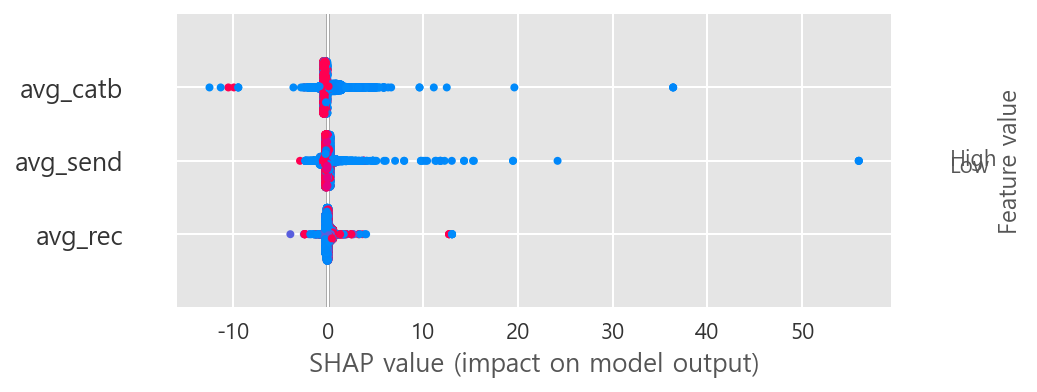

In [44]:
interpret_model(tuned_lgbm)

In [45]:
predictions = predict_model(tuned_lgbm, data = X_test)
submission['운송장_건수'] = predictions['Label']
submission.to_csv('C:/Users/SisLab/!SOYEON/물류유통량예측경진대회/minmax_catboost_pycaret_try.csv',index=False)
submission.head()

,index,운송장_건수
0,0,8.913268
1,1,5.172188
2,2,5.807481
3,3,3.775320
4,4,4.199509
